In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pickle
import json
import pyperclip
%matplotlib inline

In [2]:
with open('data/preprocessed_dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)
    
#df = pd.read_csv(os.path.join("data", "preprocessed.csv")).astype(dtypes)
df = pd.read_csv(os.path.join("data", "week1_preprocessed.csv")).astype(dtypes)

In [3]:
df.columns

Index(['Unnamed: 0', 'admission_id', 'patient_id', 'race', 'gender', 'age',
       'weight', 'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [4]:
# Add extra "is_insured" column, based on the payer code
df['is_insured'] = df.payer_code.fillna('BC').apply(lambda x: 'insured' if np.nan_to_num(x) == 'SP' else 'not insured').astype('category')
df['age'] = df.age.apply(lambda x: str(x)).astype('category')

In [5]:
df_readmitted = df[df.readmitted]

In [6]:
print(df.shape)
print(df_readmitted.shape)

(9694, 36)
(1274, 36)


In [7]:
def plot_(sensitive_class, bars_width=0.15):
    df_1 = df[sensitive_class].value_counts().sort_index()
    df_2 = df_readmitted[sensitive_class].value_counts().sort_index()

    X_axis = np.arange(len(df_1))

    width = bars_width
    num_bars = 2
    bar_pos = [ i - num_bars/2 + 0.5 for i in range(num_bars) ] # Calulation to retrieve the bar position in relation to the center

    plt.bar(X_axis + width*bar_pos[0], df_1.values / df.shape[0], label = "whole dataset", width=width)
    plt.bar(X_axis + width*bar_pos[1], df_2.values / df_readmitted.shape[0], label = "readmitted-subset", width=width)

    plt.xticks(X_axis, df_1.index) #, rotation=90)
    #plt.xlabel("Groups")
    plt.ylabel("Normalized occurrence")
    #plt.title("Number of Students in each group")
    plt.legend()


    plt.gcf().set_size_inches(4,4)
    plt.gcf().savefig("images/discrim_global_" + sensitive_class + ".pdf")
    plt.show()


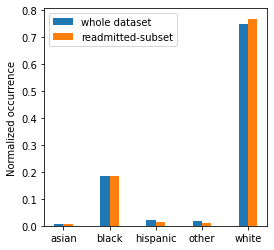

In [8]:
plot_('race', bars_width=0.2)

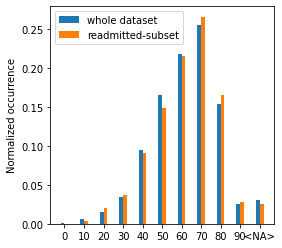

In [9]:
plot_('age', bars_width=0.2)

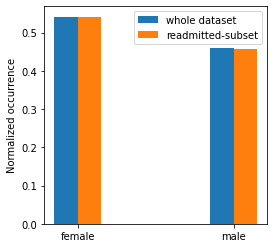

In [10]:
plot_('gender')

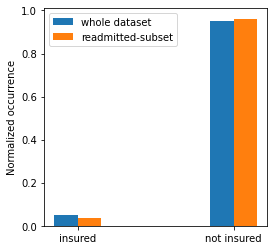

In [11]:
plot_('is_insured')

## Insurance status

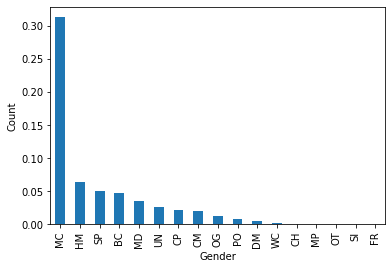

In [12]:
(df.payer_code.value_counts() / df.shape[0]).plot(kind='bar');
plt.xlabel('Gender');
plt.ylabel('Count');

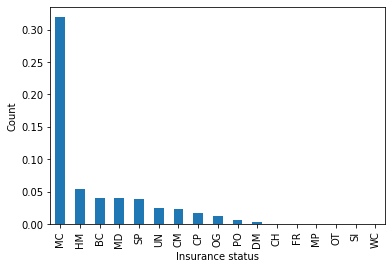

In [13]:
(df_readmitted.payer_code.value_counts() / df_readmitted.shape[0]).plot(kind='bar');
plt.xlabel('Insurance status');
plt.ylabel('Count');

In [14]:
#is_insured = df.payer_code == 'SP'

#df.readmitted.groupby()

#(df.payer_code == 'SP'.value_counts() / df.shape[0]).plot(kind='bar');
#plt.xlabel('Gender');
#plt.ylabel('Count');

In [15]:
def get_descrimination_dict(df, sensitive_columns=['age', 'race', 'gender', 'is_insured'], target='readmitted'):
    """ 
    Builds a dictionary with average target ocurrence per sensitive class per medical specialty:
    Example:
    {
        "sensitive_class": {
            "specialty1": [0.5, 0.4, 0,5]
            "specialty2": [0.1, 0.2, 0,3]
            "class_order": ['sensitive_class1', 'sensitive_class2', 'sensitive_class3']
    }
    """
    
    specialties = df['medical_specialty'].unique()
        
    result = {}
    for sensitive_column in sensitive_columns:
        classes = sorted([ str(x) for x in df[sensitive_column].unique() ])
        classes.append('overall')
        
        result[sensitive_column] = {}
        result[sensitive_column]['classes_order'] = classes # Preserve the order we iterate through sensitive class
        
        for class_ in classes:
            for specialty in specialties:
                medical_encounters = df[(df.medical_specialty == specialty)]

                if class_ != 'overall':
                    # Filter the medical encounters that have the current sensitive class
                    medical_encounters = medical_encounters[medical_encounters[sensitive_column] == class_]
                
                try:
                    result[sensitive_column][specialty].append(
                        medical_encounters[target].mean()
                    )
                except KeyError:
                    result[sensitive_column][specialty] = [
                        medical_encounters[target].mean()
                    ]
    
    return result
        
# print(json.dumps(verify_descrimination(df)))

In [21]:
def normalize(df, drop_overall = True):
    """ Normalize the sensitive class rate to the overall specialty rate
    """
    df_ = df.copy()
    for column in df_.columns:
        if column != 'overall':
            df_[column] = df_[column] / df_['overall']
    
    if drop_overall:
        df_ = df_.drop('overall', axis=1)
        
    return df_

def dict_to_df(dict_, sensitive_class):
    return pd.DataFrame.from_dict(dict_[sensitive_class]).set_index('classes_order').T

def get_descrimination_dataframe(descrimination_dict):
    """ Merge all sensitive classes dict into the same dataframe
    """
    # merge the different sensitive classes into the same df
    df_ = (dict_to_df(descrimination_dict, 'age').drop(['overall'], axis=1) # '<NA>'
     .join(dict_to_df(descrimination_dict, 'gender').drop(['nan', 'overall'], axis=1))
     .join(dict_to_df(descrimination_dict, 'race').drop(['nan', 'overall'], axis=1))
     .join(dict_to_df(descrimination_dict, 'is_insured')) #.drop('nan', axis=1))
     #.drop(np.nan)
    )

    # Normalize everythin to the overall rate and keep the column
    df_ = normalize(df_, False)

    # Round everything to 2 decimal places
    #for  column in list(df_.columns):
    #    df_[column] = df_[column].apply(lambda x: x if type(x) is str else round(x, 2))

    return df_

In [22]:
# The wrongful discharge rate, or readmission rate, 
# should not vary more than 10 percentage points between sub-groups,
# and less than 5 percentage points between medical specialties.

# Variables that may identify descrimination:

# readmitted
# time_in_hospital
# num_lab_procedures
# number_diagnoses
# change

readmitted_descrimination_dict = get_descrimination_dict(df, target='readmitted')
#time_in_hospital_descrimination_dict = get_descrimination_dict(df, target='time_in_hospital')
#num_lab_procedures_descrimination_dict = get_descrimination_dict(df, target='num_lab_procedures')
#number_diagnoses_descrimination_dict = get_descrimination_dict(df, target='number_diagnoses')
#change_descrimination_dict = get_descrimination_dict(df, target='change')

readmission_descrimination_df = get_descrimination_dataframe(readmitted_descrimination_dict)
#time_in_hospital_descrimination_df = get_descrimination_dataframe(time_in_hospital_descrimination_dict)
#num_lab_procedures_descrimination_df = get_descrimination_dataframe(num_lab_procedures_descrimination_dict)
#number_diagnoses_descrimination_df = get_descrimination_dataframe(number_diagnoses_descrimination_dict)
#change_descrimination_df = get_descrimination_dataframe(change_descrimination_dict)


In [23]:
df[(df.medical_specialty == 'Hematology')]

,Unnamed: 0,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted,is_insured
155,155,87517,46824588,white,female,60,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,14.4,False,NaN,NaN,False,False,False,False,False,not insured
339,339,81734,177412374,white,female,70,<NA>,Urgent,Discharged to home,Physician Referral,...,14.6,False,NaN,NaN,False,True,True,True,False,not insured
558,558,88632,2628180,white,female,60,<NA>,Emergency,Discharged to home,Emergency Room,...,13.8,False,NaN,NaN,False,True,False,True,False,not insured
845,845,92455,77787702,white,female,70,<NA>,Elective,Discharged to home,Physician Referral,...,13.1,True,NaN,NaN,False,True,True,True,False,not insured
859,859,99387,48138516,white,female,80,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,14.4,False,NaN,NaN,False,False,False,False,True,not insured
1244,1244,86662,2628180,white,female,60,<NA>,Elective,Discharged to home,Physician Referral,...,13.6,False,NaN,NaN,False,True,True,True,False,not insured
1591,1591,87441,47425824,white,male,70,<NA>,Urgent,Discharged/transferred to home with home healt...,NaN,...,14.8,False,NaN,NaN,False,False,False,True,True,not insured
1630,1630,86984,200465640,white,female,70,<NA>,Elective,Discharged to home,Physician Referral,...,13.2,True,NaN,NaN,False,False,False,False,True,not insured
2878,2878,83667,47425824,white,male,70,<NA>,Urgent,Discharged/transferred to home with home healt...,NaN,...,15.6,False,NaN,NaN,False,False,False,False,False,not insured
3426,3426,96036,55344960,white,female,70,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,13.8,False,NaN,NaN,False,True,True,True,False,not insured


In [24]:
df[(df.medical_specialty == 'Hematology')][df.is_insured == 'insured']

/Users/rafael.gil/.virtualenvs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted,is_insured
5126,5126,94243,84410856,white,female,70,<NA>,Urgent,Hospice / home,Physician Referral,...,13.4,False,NaN,NaN,False,True,False,True,False,insured


In [25]:
df[(df.medical_specialty == 'Hematology')][df.is_insured == 'not insured']

/Users/rafael.gil/.virtualenvs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,...,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted,is_insured
155,155,87517,46824588,white,female,60,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,14.4,False,NaN,NaN,False,False,False,False,False,not insured
339,339,81734,177412374,white,female,70,<NA>,Urgent,Discharged to home,Physician Referral,...,14.6,False,NaN,NaN,False,True,True,True,False,not insured
558,558,88632,2628180,white,female,60,<NA>,Emergency,Discharged to home,Emergency Room,...,13.8,False,NaN,NaN,False,True,False,True,False,not insured
845,845,92455,77787702,white,female,70,<NA>,Elective,Discharged to home,Physician Referral,...,13.1,True,NaN,NaN,False,True,True,True,False,not insured
859,859,99387,48138516,white,female,80,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,14.4,False,NaN,NaN,False,False,False,False,True,not insured
1244,1244,86662,2628180,white,female,60,<NA>,Elective,Discharged to home,Physician Referral,...,13.6,False,NaN,NaN,False,True,True,True,False,not insured
1591,1591,87441,47425824,white,male,70,<NA>,Urgent,Discharged/transferred to home with home healt...,NaN,...,14.8,False,NaN,NaN,False,False,False,True,True,not insured
1630,1630,86984,200465640,white,female,70,<NA>,Elective,Discharged to home,Physician Referral,...,13.2,True,NaN,NaN,False,False,False,False,True,not insured
2878,2878,83667,47425824,white,male,70,<NA>,Urgent,Discharged/transferred to home with home healt...,NaN,...,15.6,False,NaN,NaN,False,False,False,False,False,not insured
3426,3426,96036,55344960,white,female,70,<NA>,NaN,Discharged/transferred to home with home healt...,NaN,...,13.8,False,NaN,NaN,False,True,True,True,False,not insured


In [ ]:
pyperclip.copy(readmission_descrimination_df.round(2).to_latex())

In [26]:
def is_descrimination(value, threshold):
    value_ = np.nan_to_num(value)
    
    if type(value_) is str or value_ == -1:
        return '-' #'-'
    elif value_ == 0:
        return '\\tiny{0}'
    elif value_ > 1 + threshold:
        return '\\textbf{' + str('%.2f' % value_) + '}' #'A' # Above threshold
    elif value_ < 1 - threshold:
        return '\\underline{' + str('%.2f' % value_) + '}' #'B' # Below threshold
    else:
        return '%.2f' % value_

def find_descrimination(df, threshold):
    df_ = df.copy()
    df_ = df_.fillna(-1)
    
    for column in df_.columns:
        if column == 'overall':
            df_[column] = df_[column].apply(lambda x: '%.2f' % x)    
        else:
            df_[column] = df_[column].apply(lambda x: is_descrimination(x, threshold))
    
    return df_

In [27]:
readmission_descrimination_matrix = find_descrimination(readmission_descrimination_df, 0.25)
#time_in_hospital_descrimination_matrix = find_descrimination(time_in_hospital_descrimination_df, 0.5)
#num_lab_procedures_descrimination_matrix = find_descrimination(num_lab_procedures_descrimination_df, 0.5)
#number_diagnoses_descrimination_matrix = find_descrimination(number_diagnoses_descrimination_df, 0.2)
#change_descrimination_matrix = find_descrimination(change_descrimination_df, 0.5)

In [28]:
readmission_descrimination_matrix
pyperclip.copy(readmission_descrimination_matrix.to_latex())

# Worst offenders
# - race - 50%
# Radiology
# Orthopedics
# PhysicalMedicine
# ?? Hematology
# Pediatrics
# Urology
# Pulmonology
# Oncology
# Podiatry
# Endocrinology
# InfectiousDiseases

# - age - 20%
# Radiology
# PhysicalMedicine
# Psychiatry
# Others
# Pediatrics
# Anesthesiology
# Podiatry
# Endocrinology
# InfectiousDiseases

# - age - 100%
# Emergency/Trauma
# Radiology
# Cardiology
# PhysicalMedicine
# Hematology
# Pediatrics
# Nephrology
# Urology
# Podiatry

In [ ]:
def plot_descrimination_histogram(sensitive_class, specialties, bars_width=0.15):
    df_ = normalize(dict_to_df(readmitted_descrimination_dict, sensitive_class))

    df_ = df_.T[specialties].T.fillna(0) #.drop('nan', axis=1)

    X = specialties
    X_axis = np.arange(len(X))


    width = bars_width
    num_bars = len(df_.columns)
    bar_pos = [ i - num_bars/2 + 0.5 for i in range(num_bars) ] # Calulation to retrieve the bar position in relation to the center

    count = 0
    for class_ in df_.columns:
        plt.bar(X_axis + width*bar_pos[count], df_[class_].values, label = class_, width=width)
        count += 1

    plt.xticks(X_axis, X, rotation=90)
    #plt.xlabel("Groups")
    plt.ylabel("Specialty-normalized readmission rate")
    #plt.title("Number of Students in each group")
    plt.legend()


    plt.gcf().set_size_inches(16,4)
    plt.gcf().savefig("images/descrimination_histogram_" + sensitive_class + ".pdf")
    plt.show()


In [ ]:
race_worst_offenders = ['Radiology', 'Orthopedics', 'PhysicalMedicine', 'Pediatrics', 'Urology', 'Pulmonology', 'Oncology', 'Podiatry','InfectiousDiseases']

plot_descrimination_histogram('race', race_worst_offenders, 0.1)


In [ ]:
gender_worst_offenders = ['Radiology', 'PhysicalMedicine', 'Psychiatry', 'Others', 'Pediatrics', 'Anesthesiology', 'Podiatry', 'Endocrinology', 'InfectiousDiseases']

plot_descrimination_histogram('gender', gender_worst_offenders, 0.3)

In [ ]:
age_worst_offenders = ['Emergency/Trauma', 'Radiology', 'Cardiology', 'PhysicalMedicine', 'Hematology', 'Pediatrics', 'Nephrology', 'Urology','Podiatry']

plot_descrimination_histogram('age', age_worst_offenders, 0.08)

In [ ]:
age_worst_offenders = ['Emergency/Trauma', 'Radiology', 'Cardiology', 'PhysicalMedicine', 'Hematology', 'Pediatrics', 'Nephrology', 'Urology','Podiatry']

plot_descrimination_histogram('age', age_worst_offenders, 0.08)

In [ ]:
insured_worst_offender = ['Hematology', 'Urology', 'Gastroenterology', 'Emergency/Trauma', 'Nephrology', 'Radiology', 'Family/GeneralPractice', 'Orthopedics', 'Psychiatry',]
plot_descrimination_histogram('is_insured', insured_worst_offender, 0.3)